In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
import math
%matplotlib inline
sns.set_style("white")
plt.style.use('seaborn')
# sns.set_palette("white")

### Importing and Data Prep 

##### First lets read in the downloaded data from the state's DMV (scraped by AtlasEVHub.com) and can be downloaded here https://www.atlasevhub.com/materials/state-ev-registration-data/#data-format![image.png](attachment:image.png)

Because I will only be focusing on cars that require the use of charging stations, I am narrowing down my results to BEV's or Battery Electric vehicles and then checking to may sure my filter applied by doing a value count to ensure all vehicles are in fact battery powered. 

In [4]:
df_raw = pd.read_csv('data/fl_ev_registrations_public.csv')
df_raw = df_raw[(df_raw.Technology == 'BEV')]
df_raw.info()
df_raw['Vehicle Name'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249641 entries, 0 to 353791
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DMV ID                        249641 non-null  int64  
 1   DMV Snapshot (Date)           249641 non-null  object 
 2   County                        249641 non-null  object 
 3   Vehicle Name                  249641 non-null  object 
 4   Registration Valid Date       249641 non-null  object 
 5   Registration Expiration Date  0 non-null       float64
 6   Technology                    249641 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 15.2+ MB


Tesla Model 3                    91019
Tesla Model S                    59058
Tesla Model X                    30887
Tesla Model Y                    18856
Nissan Leaf                      16295
Chevrolet Bolt EV                 8484
BMW i3                            6282
Smart forTwo EV                   4695
Audi e-tron                       2738
Porsche Taycan                    2052
Fiat 500e                         1948
Jaguar I-Pace                     1898
Volkswagen ID.4                    611
Ford Focus EV                      607
Volkswagen e-Golf                  552
Chevrolet Spark                    492
Smart forTwo EV Cabrio             438
Audi e-tron Sportback              373
Mercedes B-Class Electric          344
Kia Soul EV                        313
Tesla Roadster                     295
Mitsubishi i                       288
Kia Niro EV                        280
Hyundai Kona Electric              170
Ford Mustang Mach-E                156
Mini Hardtop 2 Door EV   

For my analyses, since my primary focus is the growth of electric vehicles, I will create a new dataframe based on the count of vehicles being registered per year. 

In [6]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])
years.head()

,Year,Registered Vehicles
0,7/19/2021,70279
1,12/31/2020,52877
2,6/30/2020,43123
3,12/31/2019,39789
4,12/31/2018,25458


,Registered Vehicles
Year,
2018-06-30,18115.0
2018-12-31,25458.0
2019-12-31,39789.0
2020-06-30,43123.0
2020-12-31,52877.0
2021-07-19,70279.0


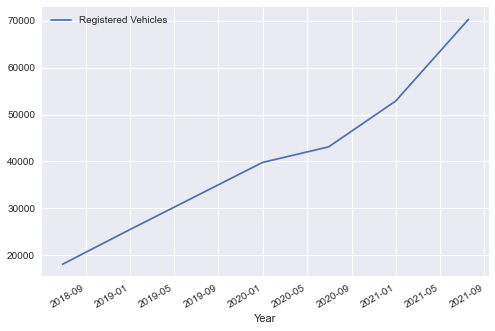

In [7]:
df = pd.DataFrame(years['Registered Vehicles']).set_axis(pd.to_datetime(years['Year'])).sort_values(by=['Year'], ascending = True).astype(float)
df.plot()
df

Here we see an upwards trend of EV's on the road from 2018 to 2021 as expected due to the surge of electric vehicles on the road these past few years. 

In [ ]:
# result = seasonal_decompose(df, model='multiplicative')
# fig = result.plot()


## **RESAMPLING

In [ ]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [ ]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

In [ ]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

In [ ]:
auto_model = pm.auto_arima(df, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())


## Testing 

In [ ]:
adtest = adfuller(df)
display(adtest)

## Modeling

In [ ]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2018-06-30':'2020-12-31']
test = df['2020-12-31':]
combined = df

test

In [ ]:
naive = train.shift(1)
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

In [ ]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



### The best model is :  ARIMA (1,00) (0,0,0) [0]

In [ ]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

*mention about data behavior in markdown

In [ ]:
pred = output.get_prediction(start=pd.to_datetime('2020-12-31'), end=pd.to_datetime('2021-07-19'), dynamic=False)
pred_conf = pred.conf_int()


In [ ]:

sns.set_style(style='white')
rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=20)
ax.set_ylabel('Quantity (in ten thousands) ',fontsize=30)
ax.tick_params(axis='x', which='minor', labelsize=20)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Florida Performance Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [ ]:
# Beginning our forecasting for next 3 years (36 months)
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
forecast = full_output.get_forecast(48)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

August of 2024: 

301180 EV's on the road

In [ ]:
sns.set_style(style='white')
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Actual')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'], color = 'lightblue',
                label='Confidence Interval')


ax.set_xlabel('Year',fontsize=30)
plt.xticks(fontsize=20)
ax.set_ylabel('Number of EVs (hundred thousands)',fontsize=30)
plt.yticks(fontsize=20)

scale_y = 1e5
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Florida Battery EV Forecast',fontsize=30)
plt.legend(fontsize = 15)
plt.show()

In [ ]:
MSE = mean_squared_error(test, pred_conf['lower Registered Vehicles'])
 
RMSE = math.sqrt(MSE)
print(RMSE)